In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('NEU Metal Surface Defects Data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2025-01-24 22:45:16.260795: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-24 22:45:16.270153: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737747916.281017   95654 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737747916.284083   95654 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-24 22:45:16.295912: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

NEU Metal Surface Defects Data/Thumbs.db
NEU Metal Surface Defects Data/train/Crazing/Cr_122.bmp
NEU Metal Surface Defects Data/train/Crazing/Cr_297.bmp
NEU Metal Surface Defects Data/train/Crazing/Cr_217.bmp
NEU Metal Surface Defects Data/train/Crazing/Cr_249.bmp
NEU Metal Surface Defects Data/train/Crazing/Cr_291.bmp
NEU Metal Surface Defects Data/train/Crazing/Cr_238.bmp
NEU Metal Surface Defects Data/train/Crazing/Cr_37.bmp
NEU Metal Surface Defects Data/train/Crazing/Cr_32.bmp
NEU Metal Surface Defects Data/train/Crazing/Cr_25.bmp
NEU Metal Surface Defects Data/train/Crazing/Cr_42.bmp
NEU Metal Surface Defects Data/train/Crazing/Cr_198.bmp
NEU Metal Surface Defects Data/train/Crazing/Cr_165.bmp
NEU Metal Surface Defects Data/train/Crazing/Cr_270.bmp
NEU Metal Surface Defects Data/train/Crazing/Cr_87.bmp
NEU Metal Surface Defects Data/train/Crazing/Cr_160.bmp
NEU Metal Surface Defects Data/train/Crazing/Cr_213.bmp
NEU Metal Surface Defects Data/train/Crazing/Cr_274.bmp
NEU Metal Su

In [34]:
#check if gpu is enabled
print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# with tf.device('/device:GPU:0'):
#     history=model.fit(dataSetGenerator,
#                       epochs=1,
#                       steps_per_epoch=self.steps_per_epoch)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [2]:
train_dir = "./NEU Metal Surface Defects Data/train"
test_dir = "./NEU Metal Surface Defects Data/test"
valid_dir = "./NEU Metal Surface Defects Data/valid"

# Data preprocessing before modeling

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)


#get the images from train datagen
train_generator = train_datagen.flow_from_directory(train_dir,
                                              target_size=(200, 200),
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=True)
valid_generator = test_datagen.flow_from_directory(valid_dir,
                                              target_size=(200, 200),
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=False)

test_generator = test_datagen.flow_from_directory(test_dir,
                                              target_size=(200, 200),
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=False)

Found 1656 images belonging to 6 classes.
Found 72 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


In [4]:
#checking for batch size
for image_batch , labels_batch in train_generator :
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 200, 200, 3)
(32, 6)


In [5]:
#checking for class names
class_names = train_generator.class_indices
class_names = list(class_names.keys())
print(class_names)

['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']


# Sample images 

In [6]:
#making functions
def get_sample_image(generator):
    images, labels = next(generator)
    image = images[0]
    label_index = np.argmax(labels[0])
    label_name = class_names[label_index]

    return image, label_name


def sample_images(generator, nrows=3, ncols=3):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
    
    for i in range(nrows*ncols):
        image, label_name = get_sample_image(generator)
        row = i // ncols
        col = i % ncols
        ax = axes[row][col]
        ax.imshow(image)
        ax.set_title(label_name)
        ax.axis('off')

    plt.show()

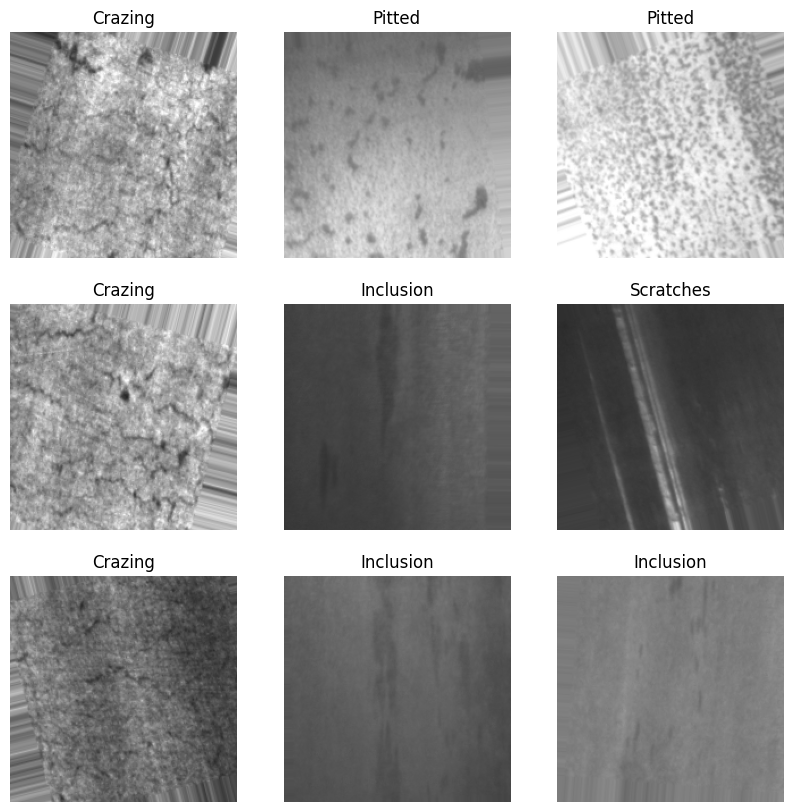

In [7]:
sample_images(train_generator, nrows=3, ncols=3)

In [8]:
image_batch

array([[[[0.8142236 , 0.8142236 , 0.8142236 ],
         [0.8265986 , 0.8265986 , 0.8265986 ],
         [0.8389735 , 0.8389735 , 0.8389735 ],
         ...,
         [0.5162811 , 0.5162811 , 0.5162811 ],
         [0.588923  , 0.588923  , 0.588923  ],
         [0.6280872 , 0.6280872 , 0.6280872 ]],

        [[0.76073444, 0.76073444, 0.76073444],
         [0.7731094 , 0.7731094 , 0.7731094 ],
         [0.7854844 , 0.7854844 , 0.7854844 ],
         ...,
         [0.5339596 , 0.5339596 , 0.5339596 ],
         [0.5986461 , 0.5986461 , 0.5986461 ],
         [0.6298551 , 0.6298551 , 0.6298551 ]],

        [[0.7411765 , 0.7411765 , 0.7411765 ],
         [0.7411765 , 0.7411765 , 0.7411765 ],
         [0.7411765 , 0.7411765 , 0.7411765 ],
         ...,
         [0.5516381 , 0.5516381 , 0.5516381 ],
         [0.60836935, 0.60836935, 0.60836935],
         [0.63162297, 0.63162297, 0.63162297]],

        ...,

        [[0.8812813 , 0.8812813 , 0.8812813 ],
         [0.8149497 , 0.8149497 , 0.8149497 ]

# Deep learning model using CNN

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.applications.efficientnet import EfficientNetB7

In [10]:
model1 = Sequential([ Conv2D(32, (2, 2), activation='relu', input_shape=(200, 200, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (2, 2), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (2, 2), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(6 ,activation='softmax')])

/home/cago/MECH536/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1737747934.351796   95654 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5719 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [11]:
model1.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [12]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 199, 199, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 98, 98, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 49, 49, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    18,874,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,917,734 (72.17 MB)

 Trainable params: 18,917,734 (72.17 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
with tf.device('/gpu:0'):
    
    history = model1.fit(train_generator,
                        epochs=20,
                        batch_size=32,
                        validation_data=valid_generator)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.9062 - loss: 0.2536 - val_accuracy: 0.9583 - val_loss: 0.1772
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.9056 - loss: 0.2870 - val_accuracy: 0.9306 - val_loss: 0.2217
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.9212 - loss: 0.2242 - val_accuracy: 0.9444 - val_loss: 0.1741
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.9477 - loss: 0.1557 - val_accuracy: 0.8889 - val_loss: 0.4568
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.9324 - loss: 0.1782 - val_accuracy: 0.9028 - val_loss: 0.3281
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.9407 - loss: 0.1805 - val_accuracy: 0.8750 - val_loss: 0.4291
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.9425 - loss: 0.1529 - val_accuracy: 1.0000 - val_loss: 0.0478
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.9263 - loss: 0.2057 - val_accuracy: 0.

# Model 1 Evaluate

In [16]:
def plot_history(history,metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_"+metric],"")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_"+metric])
    plt.show()

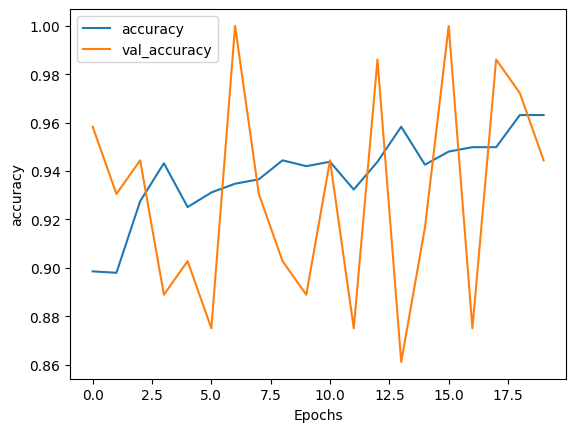

In [17]:
plot_history(history,"accuracy")

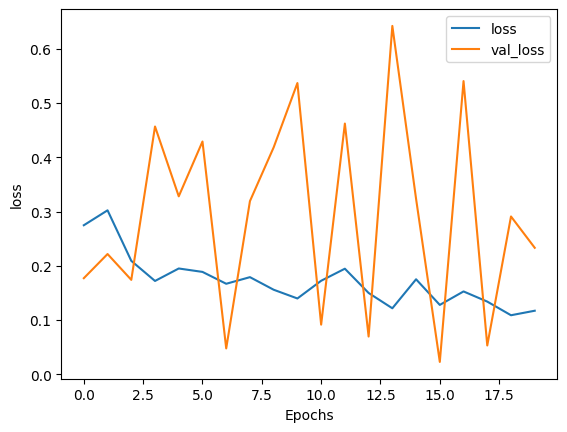

In [18]:
plot_history(history,"loss")

In [19]:
result = model1.evaluate(test_generator)
print("Test loss, Test accuracy : ", result)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9714 - loss: 0.1077
Test loss, Test accuracy :  [0.14047008752822876, 0.9583333134651184]


/home/cago/MECH536/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [20]:
base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top = False , weights = 'imagenet' ,
                                                               input_shape = (200,200,3), pooling= 'max')
model2 = Sequential([ Conv2D(32, (2, 2), activation='relu', input_shape=(200, 200, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (2, 2), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (2, 2), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(6 ,activation='softmax')])

/home/cago/MECH536/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
model2.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [22]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 199, 199, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 98, 98, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 49, 49, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 48, 48, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    18,874,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,917,734 (72.17 MB)

 Trainable params: 18,917,734 (72.17 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
with tf.device('/gpu:0'):

    history2 = model2.fit(train_generator,
                        epochs=20,
                        batch_size=32,
                        validation_data=valid_generator)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - accuracy: 0.2308 - loss: 2.0616 - val_accuracy: 0.7639 - val_loss: 0.9878
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.6545 - loss: 0.9787 - val_accuracy: 0.6528 - val_loss: 0.8627
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.7547 - loss: 0.6450 - val_accuracy: 0.7639 - val_loss: 0.5456
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.8094 - loss: 0.5013 - val_accuracy: 0.8889 - val_loss: 0.4225
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.7269 - loss: 0.7505 - val_accuracy: 0.7361 - val_loss: 0.8822
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.8731 - loss: 0.3998 - val_accuracy: 0.9167 - val_loss: 0.2642
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.8678 - loss: 0.3432 - val_accuracy: 0.9306 - val_loss: 0.2485
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.9037 - loss: 0.2853 - val_accuracy: 0.

# Model 2 Evaluate

In [24]:
def plot_history(history, metric):
    plt.plot(history2.history[metric])
    plt.plot(history2.history['val_'+metric], '')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

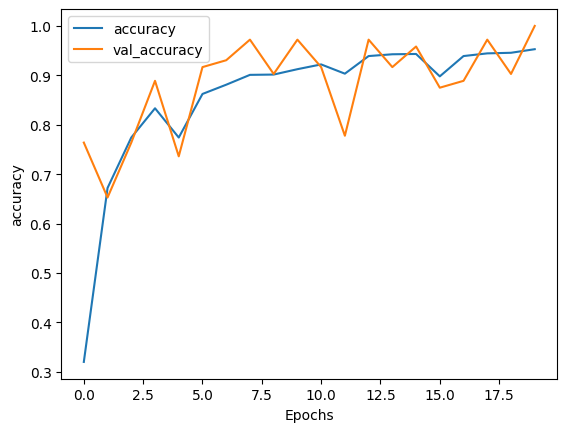

In [25]:
plot_history(history, 'accuracy')

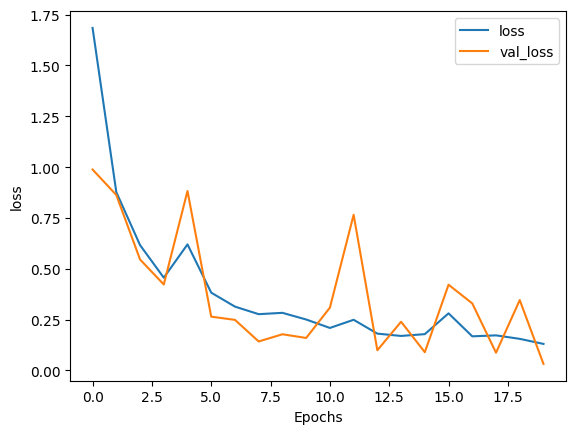

In [26]:
plot_history(history, 'loss')

In [27]:
result = model2.evaluate(test_generator)
print("Test loss, Test accuracy : ", result)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9280 - loss: 0.2078
Test loss, Test accuracy :  [0.26737383008003235, 0.9027777910232544]


# Visualize Predicted Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


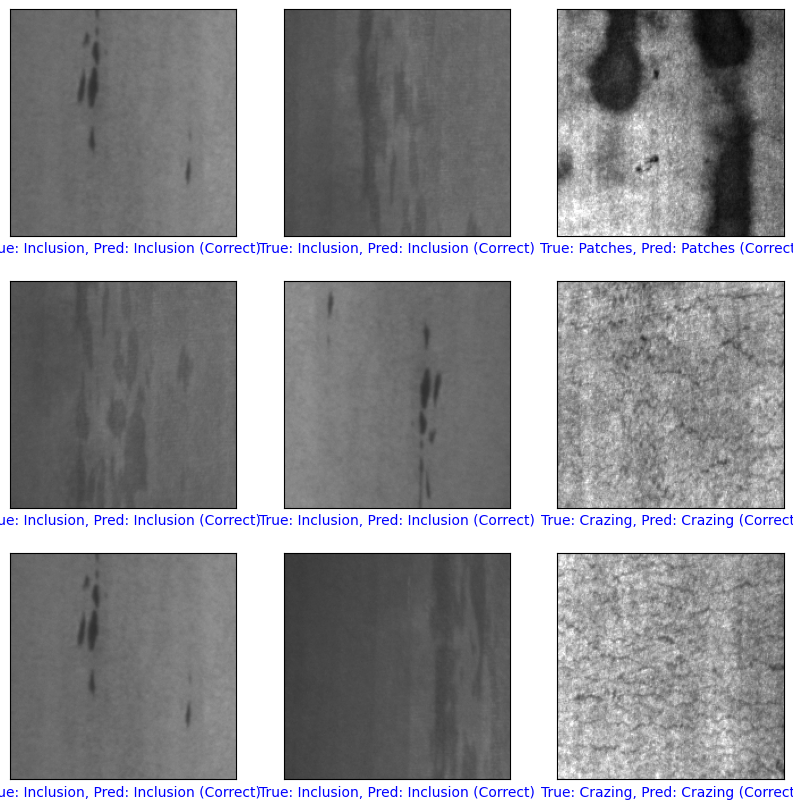

In [28]:
images, labels = next(test_generator)    

indices = np.random.choice(range(len(images)), size=9)
images = images[indices]
labels = labels[indices]

predictions = model1.predict(images)


class_names=list(test_generator.class_indices.keys())


plt.figure(figsize=(10,10))
    
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
        
    image = images[i]
        
    if image.shape[-1] == 1:
        image = np.squeeze(image) 
        
    plt.imshow(image)
        
    predicted_label = np.argmax(predictions[i])
        
    if predicted_label == np.argmax(labels[i]):
        color='blue'
        result_text="Correct"
            
    else:
        color='red'
        result_text="Incorrect"

    label_text="True: "+ class_names[np.argmax(labels[i])] + ", Pred: " + class_names[predicted_label] + f" ({result_text})"        
            
    plt.xlabel(label_text,color=color)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


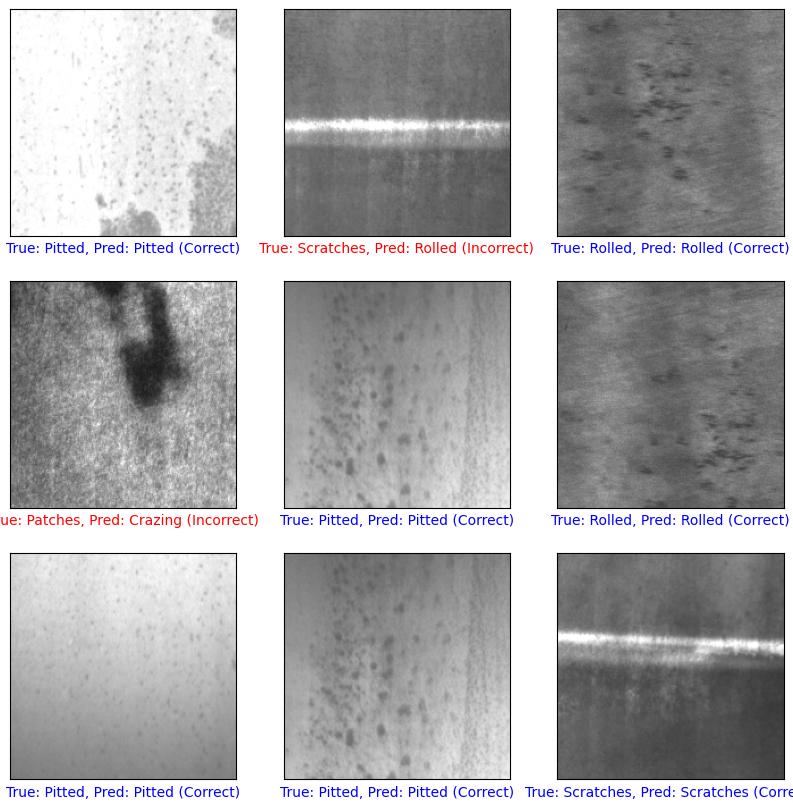

In [30]:
images, labels = next(test_generator)    

indices = np.random.choice(range(len(images)), size=9)
images = images[indices]
labels = labels[indices]

predictions = model2.predict(images)


class_names=list(test_generator.class_indices.keys())


plt.figure(figsize=(10,10))
    
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
        
    image = images[i]
        
    if image.shape[-1] == 1:
        image = np.squeeze(image) 
        
    plt.imshow(image)
        
    predicted_label = np.argmax(predictions[i])
        
    if predicted_label == np.argmax(labels[i]):
        color='blue'
        result_text="Correct"
            
    else:
        color='red'
        result_text="Incorrect"

    label_text="True: "+ class_names[np.argmax(labels[i])] + ", Pred: " + class_names[predicted_label] + f" ({result_text})"        
            
    plt.xlabel(label_text,color=color)

# Comparing between two models

In [31]:
import pandas as pd

# Define the accuracy and loss values for both models
model1_accuracy = history.history['accuracy'][-1]
model1_loss = history.history['loss'][-1]
model2_accuracy = history2.history['accuracy'][-1]
model2_loss = history2.history['loss'][-1]


# Create a dictionary with the accuracy and loss values
data = {'Model': ['Model 1', 'Model 2'],
        'Accuracy': [model1_accuracy, model2_accuracy],
        'Loss': [model1_loss, model2_loss]}

df = pd.DataFrame(data)
df

,Model,Accuracy,Loss
0,Model 1,0.963164,0.117222
1,Model 2,0.952899,0.130279


In [32]:
from sklearn.cluster import KMeans
import numpy as np

# 1) Modify your code to extract features from your trained model
#    We can define a "feature-extractor" model that stops at the second-to-last layer

feature_model = keras.Model(
    inputs=model1.input,
    outputs=model1.layers[-2].output  # e.g., the Dense(256) layer, if your final layer is Dense(6)
)

# 2) Collect features for all training images
train_features = []
train_labels = []  # optional, just to compare if you'd like

train_generator.reset()
for batch_index in range(len(train_generator)):
    images, labels = next(train_generator, (None, None))
    if images is None:
        break
    feats = feature_model.predict(images)
    train_features.append(feats)
    train_labels.append(labels)

train_features = np.concatenate(train_features, axis=0)
train_labels = np.concatenate(train_labels, axis=0)

print("Shape of train_features:", train_features.shape)

# 3) Run k-means (assuming 6 known defect classes):
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(train_features)

# 4) Inference on new data:
test_generator.reset()
for batch_index in range(len(test_generator)):
    images, labels = next(test_generator, (None, None))
    if images is None:
        break

    # a) CNN’s softmax classification
    cnn_preds = model1.predict(images)
    top_class = np.argmax(cnn_preds, axis=1)

    # b) Feature-based clustering
    feats_test = feature_model.predict(images)
    cluster_assignments = kmeans.predict(feats_test)

    # c) Distance from cluster center 
    distances = []
    for i in range(len(cluster_assignments)):
        center = kmeans.cluster_centers_[cluster_assignments[i]]
        dist = np.linalg.norm(feats_test[i] - center)
        distances.append(dist)

    # Threshold for novelty
    DIST_THRESHOLD = 10.0  # You’ll pick or tune

    for i, dist in enumerate(distances):
        if dist > DIST_THRESHOLD:
            print(f"Image {i} might be novel! Distance to cluster center: {dist:.2f}")
            # Prompt user or handle it as you like


AttributeError: The layer sequential has never been called and thus has no defined input.